In [102]:
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *

In [121]:
data = loadmatInPy("D:/Analyzed/asli_1-18-7-19_E2_analyzed.mat")

In [122]:
data[0]['spikeindices']-1

array([   3492,    3660,    4683, ..., 7197424, 7199607, 7199748])

In [148]:
import numpy as np

def find_roc_values(spikeindices, hidden_state, duration, dt):
    Nspike = len(spikeindices)
    correctwrong = hidden_state[spikeindices]
    jumps = np.diff(hidden_state)
    jumpupindices = np.where(jumps == 1)[0]
    jumpdownindices = np.where(jumps == -1)[0]
    # Find delay since last jump for each spike
    ROC = {'correct_delayvec': [], 'wrong_delayvec': []}

    
    for ns in range(Nspike):
        if correctwrong[ns] == 1:
            # correct: find last up-jump
            njump = np.where(jumpupindices - spikeindices[ns] > 0)[0]

            if njump.size==0:
                if ns > Nspike - 50:
                    # last spike is after last jump
                    njump = np.array([len(jumpupindices)])
                else:
                    raise ValueError("Unexpected condition: last spike is before any jump")
            elif njump[0] == 0:
                # no jump up before early spike
                continue
            # else:
            njump = njump[0] - 1
            jumpindex = jumpupindices[njump]
            ROC['correct_delayvec'].append(dt * (spikeindices[ns] - jumpindex))
        elif correctwrong[ns] == 0:
            # wrong: find last down-jump
            njump = np.where(jumpdownindices - spikeindices[ns] > 0)[0]
            if njump.size==0:
                njump = np.array([len(jumpdownindices)])
            elif njump[0] == 0:
                # no jump down before early spike
                continue
            # else:
            # print(len(jumpupindices))
            njump = njump[0] - 1

            jumpindex = jumpdownindices[njump]
            ROC['wrong_delayvec'].append(dt * (spikeindices[ns] - jumpindex))
    # Find correctly detected up states, misses, false alarms, and correct rejections
    if hidden_state[0] == 1:
        # start at hidden state up, first jump is down
        if hidden_state[-1] == 1:
            # end at hidden state up, last jump is up
            ROC['Nup'] = len(jumpupindices) + 1
            ROC['Ndown'] = len(jumpdownindices)
        elif hidden_state[-1] == 0:
            # end at hidden state down, last jump is down
            ROC['Nup'] = len(jumpupindices)
            ROC['Ndown'] = len(jumpdownindices)+1
        else:
            raise ValueError("Unexpected condition: Hidden state neither 0 nor 1")


        # Check up states
        correctup = 0
        missedup = 0
        nlast = 1
        for nsu in range(ROC['Nup']):
            if nsu >= len(jumpdownindices):
                ndown = len(hidden_state)
            else:
                ndown = jumpdownindices[nsu]
            relspikes = spikeindices[(spikeindices <= ndown) & (spikeindices > nlast)]
            if not relspikes.size:
                missedup += 1
            else:
                correctup += 1
            if nsu < ROC['Nup'] - 1:
                nlast = jumpupindices[nsu]

        if not (correctup + missedup == ROC['Nup']):
            raise ValueError("Number of up states not the same as hits and misses")

        # Check down states
        correctdown = 0
        falsealarm = 0
        for nsd in range(ROC['Ndown']):
            nlast = jumpdownindices[nsd]
            if nsd >= len(jumpupindices):
                nup = len(hidden_state)
            else:
                nup = jumpupindices[nsd]
            relspikes = spikeindices[(spikeindices <= nup) & (spikeindices > nlast)]
            if not relspikes.size:
                correctdown += 1
            else:
                falsealarm += 1

        if not (correctdown + falsealarm == ROC['Ndown']):
            raise ValueError("Number of down states not the same as correct rejects and false alarm")


    elif hidden_state[0] == 0:
        # start at hidden state down, first jump is up
        if hidden_state[-1] == 1:
            # end at hidden state up, last jump is up
            ROC['Nup'] = len(jumpupindices)+1
            ROC['Ndown'] = len(jumpdownindices) 
        elif hidden_state[-1] == 0:
            # end at hidden state down, last jump is down
            ROC['Nup'] = len(jumpupindices)
            ROC['Ndown'] = len(jumpdownindices) + 1
        else:
            raise ValueError("Unexpected condition: Hidden state neither 0 nor 1")

        # Check up states
        correctup = 0
        missedup = 0
        nlast = 1
        for nsu in range(ROC['Nup']):
            if nsu >= len(jumpdownindices):
                ndown = len(hidden_state)
            else:
                ndown = jumpdownindices[nsu]
            relspikes = spikeindices[(spikeindices <= ndown) & (spikeindices > nlast)]
            if not relspikes.size:
                missedup += 1
            else:
                correctup += 1
            if nsu < ROC['Nup'] - 1:
                nlast = jumpupindices[nsu]

        if not (correctup + missedup == ROC['Nup']):
            raise ValueError("Number of up states not the same as hits and misses")

        # Check down states
        correctdown = 0
        falsealarm = 0
        for nsd in range(ROC['Ndown']):
            nlast = jumpdownindices[nsd]
            if nsd >= len(jumpupindices):
                nup = len(hidden_state)
            else:
                nup = jumpupindices[nsd]
            relspikes = spikeindices[(spikeindices <= nup) & (spikeindices > nlast)]
            if not relspikes.size:
                correctdown += 1
            else:
                falsealarm += 1

        if not (correctdown + falsealarm == ROC['Ndown']):
            raise ValueError("Number of down states not the same as correct rejects and false alarm")

    else:
        raise ValueError("Unexpected condition: Hidden state neither 0 nor 1")

    ROC['fraction_correct'] = np.sum(correctwrong) / Nspike
    ROC['nspikeperup'] = np.sum(correctwrong) / ROC['Nup']
    ROC['nspikeperdown'] = (Nspike - np.sum(correctwrong)) / ROC['Ndown']
    ROC['correctup'] = correctup / (missedup + correctup)
    ROC['missedup'] = missedup / (missedup + correctup)
    ROC['correctdown'] = correctdown / (correctdown + falsealarm)
    ROC['falsealarm'] = falsealarm / (correctdown + falsealarm)
    ROC['mean_firing_rate'] = len(spikeindices) / (duration / 1000)

    return ROC

dict_data=find_roc_values(data[0]['spikeindices']-1,np.array(data[0]['hidden_state'],dtype=np.int32),data[0]['input_generation_settings']['duration'],1/data[0]['input_generation_settings']['sampling_rate'])


In [40]:
import os 

In [149]:
path = "D:/Analyzed/"
ROC  = [] 
files = os.listdir(path)[1:]
for f in files:
    try:
        data = loadmatInPy(path +f)
        exp = f[:-13]
        
        for trial,instance in enumerate(data):
            cond = instance['input_generation_settings']['condition']
            print(exp, trial, cond)
            ROC_ = find_roc_values(instance['spikeindices']-1,np.array(instance['hidden_state'],dtype=np.float32),instance['input_generation_settings']['duration'],1/20)
            correct_delayvec  = ROC_['correct_delayvec'] 
            wrong_delayvec  = ROC_['wrong_delayvec'] 
            ROC_temp = [correct_delayvec,wrong_delayvec,cond,exp,trial]
            ROC.append(ROC_temp)
    except:
        print('problem with ',f[:-13])




asli_1-18-7-19_E2 0 ACSF
asli_1-18-7-19_E2 1 M1-ago
asli_1-18-7-19_E2 2 M1-ant
asli_11-7-19_E1 0 ACSF
asli_11-7-19_E1 1 M1-ago
asli_11-7-19_E1 2 M1-ant
asli_11-7-19_E2 0 ACSF
asli_11-7-19_E2 1 M1-ago
asli_11-7-19_E2 2 M1-ant
asli_12-7-19_E2 0 ACSF
asli_12-7-19_E2 1 M1-ago
asli_12-7-19_E2 2 M1-ant
asli_12-7-19_E3 0 ACSF
asli_12-7-19_E3 1 M1-ago
asli_12-7-19_E3 2 M1-ant
asli_15-7-19_E3 0 ACSF
asli_15-7-19_E3 1 M1-ago
asli_18-7-19_E1 0 ACSF
asli_18-7-19_E1 1 M1-ago
asli_18-7-19_E1 2 M1-ant
asli_2-8-19_E1 0 ACSF
asli_2-8-19_E1 1 M1-ago
asli_2-8-19_E1 2 M1-ago+ant
asli_2-8-19_E2 0 ACSF
asli_2-8-19_E2 1 M1-ago
asli_2-8-19_E2 2 M1-ago+ant
asli_2-8-19_E3 0 ACSF
asli_2-8-19_E3 1 M1-ago
asli_2-8-19_E3 2 M1-ago+ant
asli_23-7-19_E2 0 ACSF
asli_23-7-19_E2 1 M1-ago
asli_23-7-19_E2 2 M1-ant
asli_23-7-19_E3 0 ACSF
asli_23-7-19_E3 1 M1-ago
asli_23-7-19_E3 2 M1-ant
asli_23-7-19_E5 0 ACSF
asli_23-7-19_E5 1 M1-ago
asli_23-7-19_E5 2 M1-ant
asli_24-7-19_E4 0 ACSF
asli_24-7-19_E4 1 M1-ago
asli_24-7-19_E4 2 M

In [162]:
# ROC[0][0]
df = pd.DataFrame(columns=['correct_delay','wrong_delay','cond','exp','trial'])


# df = pd.DataFrame(columns=['sta','cond','exp_name','trial'])
for i in range(len(ROC)):
    # print(len(np.array(ROC[i][0],dtype=np.float32)))
    df.loc[i,'correct_delay'] = np.array(ROC[i][0],dtype=np.float32)
    df.loc[i,'wrong_delay'] = np.array(ROC[i][1],dtype=np.float32)
    df.loc[i,['cond','exp','trial']] = np.array(np.hstack(ROC[i])[-3:]) 

df.to_pickle('D:/CurrentClamp/all_delay_vec_hidden.pkl')

array(['ACSF', 'AgoAnta', 'Cirazoline', 'D1', 'D1ago', 'D2', 'DOPA',
       'DOPAMINE', 'Dop', 'M1-ag', 'M1-ago', 'M1-ago+ant', 'M1-ant',
       'M1-ant+ago', 'aCSF', 'aCSF_BIC', 'sag'], dtype=object)

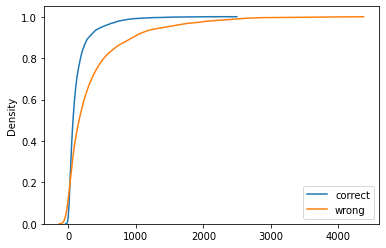

In [154]:
sns.kdeplot((np.hstack(df['correct_delay'])),cumulative=True)
sns.kdeplot((np.hstack(df['wrong_delay'])),cumulative=True)
plt.legend(['correct','wrong'])


In [9]:
import numpy as np
def entropy(p):
    return -np.sum(p*np.log2(p))

entropy([1/2,1/4,1/8,1/8])    
# p = [1/2,1/4,1/8,1/8]
# -1*sum(p*np.log2(p))

1.75

In [11]:
def mutual_information(joint_probability_distribution):
    # Calculate marginal probability distributions
    p_signal = np.sum(joint_probability_distribution, axis=0)
    p_noise = np.sum(joint_probability_distribution, axis=1)
    # Calculate entropies without flattening
    h_signal = entropy(p_signal)
    h_noise = entropy(p_noise)
    print(h_signal,h_noise)
    # Calculate joint entropy without flattening
    h_joint = entropy(joint_probability_distribution)
    # Calculate mutual information using the provided snippet
    mutual_info = 0.0
    marginal_prob_x = np.sum(joint_probability_distribution, axis=1)
    marginal_prob_y = np.sum(joint_probability_distribution, axis=0)
    for i in range(joint_probability_distribution.shape[0]):
        for j in range(joint_probability_distribution.shape[1]):
            if joint_probability_distribution[i, j] > 0:
                mutual_info += joint_probability_distribution[i, j] * np.log2(joint_probability_distribution[i, j] / (marginal_prob_x[i] * marginal_prob_y[j]))
    # Calculate mutual information
    mi = h_signal + h_noise - h_joint
    return mi
# Given joint probability distribution
joint_probability_distribution = np.array([[1/8, 1/16, 1/32, 1/32],
                                           [1/16, 1/8, 1/32, 1/32],
                                           [1/16, 1/16, 1/16, 1/16],
                                           [1/4, 0, 0, 0]])
# Calculate mutual information
mi = mutual_information(joint_probability_distribution)

1.75 2.0


<ipython-input-9-2ec81b8f577c>:3: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(p*np.log2(p))
<ipython-input-9-2ec81b8f577c>:3: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(p*np.log2(p))


In [18]:
import numpy as np

def calculate_mutual_information(x, y, bins=10):
    """
    Calculate mutual information between two continuous variables using histogram-based method.

    Parameters:
    - x: numpy array, input variable 1
    - y: numpy array, input variable 2
    - bins: number of bins for histogram discretization

    Returns:
    - mutual information value
    """

    # Create a 2D histogram
    H, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)

    # Calculate marginal entropies
    entropy_x = entropy(np.sum(H, axis=1))
    entropy_y = entropy(np.sum(H, axis=0))

    # Calculate joint entropy
    joint_entropy = entropy(H.flatten())

    # Calculate mutual information
    mutual_information = entropy_x + entropy_y - joint_entropy

    return entropy_x,mutual_information

# Example usage:
np.random.seed(42)
x = np.random.rand(1000)
# y = 0.5 * x + 0.5 * np.random.rand(1000)  # Some correlation with x
y = x
entropy_x, mutual_information = calculate_mutual_information(x, y)
print(f"Mutual Information: {mutual_information:.4f}")
print(f"entropy_x: {entropy_x:.4f}")


Mutual Information: 2.2975
entropy_x: 2.2975


In [30]:
import numpy as np
from sklearn.neighbors import KernelDensity

def calculate_mutual_information_kernel(X, Y, bandwidth=1.0, num_points=100):
    # Combine the variables into a single array
    data = np.vstack([X, Y]).T

    # Fit kernel density estimators
    kde_joint = KernelDensity(bandwidth=bandwidth).fit(data)
    kde_x = KernelDensity(bandwidth=bandwidth).fit(X.reshape(-1, 1))
    kde_y = KernelDensity(bandwidth=bandwidth).fit(Y.reshape(-1, 1))

    # Calculate log-densities
    log_density_joint = kde_joint.score_samples(data)
    log_density_x = kde_x.score_samples(X.reshape(-1, 1))
    log_density_y = kde_y.score_samples(Y.reshape(-1, 1))

    # Calculate mutual information using kernel density estimates
    mi = np.mean(log_density_joint - log_density_x - log_density_y)

    return mi
# Generate example data
np.random.seed(42)
X = np.random.rand(100)
Y = 2 * X + 0.1 * np.random.randn(100)
# Y = X
# Calculate mutual information using kernel method
mi_kernel = calculate_mutual_information_kernel(X, Y)

print(f"Mutual Information (Kernel Method): {mi_kernel}")
print(f"Entropy X: {-1*np.sum(x)}")


Mutual Information (Kernel Method): 0.026939696925345338
Entropy X: 100.2152096644681


In [31]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# Function for generating synthetic data
def generate_synthetic_data():
    np.random.seed(42)
    X = np.random.rand(100)
    Y = 2 * X + 0.1 * np.random.randn(100)
    return X, Y

# Function to test mutual information calculation
def test_mutual_information():
    # Generate synthetic data
    X, Y = generate_synthetic_data()

    # Calculate mutual information using kernel method
    mi_kernel = calculate_mutual_information_kernel(X, Y)

    # Calculate mutual information using scikit-learn's mutual_info_regression
    mi_reference = mutual_info_regression(X.reshape(-1, 1), Y)

    # Print results
    print(f"Mutual Information (Kernel Method): {mi_kernel}")
    print(f"Mutual Information (Reference): {mi_reference}")

    # Check if the results are close
    assert np.isclose(mi_kernel, mi_reference, rtol=1e-3), "Test failed: Mutual information values are not close."

# Run the test
test_mutual_information()

Mutual Information (Kernel Method): 0.026939696925345338
Mutual Information (Reference): [1.70918328]


AssertionError: Test failed: Mutual information values are not close.

In [60]:
def test_mutual_information(bandwidth=1.0):
    # Generate synthetic data
    X, Y = generate_synthetic_data()

    # Calculate mutual information using kernel method with adjustable bandwidth
    mi_kernel = calculate_mutual_information_kernel(X, Y, bandwidth=bandwidth)

    # Calculate mutual information using scikit-learn's mutual_info_regression
    mi_reference = mutual_info_regression(X.reshape(-1, 1), Y)

    # Print results
    print(f"Mutual Information (Kernel Method): {mi_kernel}")
    print(f"Mutual Information (Reference): {mi_reference}")

    # Check if the results are close
    assert np.isclose(mi_kernel, mi_reference, rtol=1e-3), "Test failed: Mutual information values are not close."

# Run the test with an adjustable bandwidth parameter
test_mutual_information(bandwidth=0.0424)


Mutual Information (Kernel Method): 1.7083996744049719
Mutual Information (Reference): [1.70918328]


In [ ]:
% Calculate the mutual information between hidden state x and generated
% input train (same size vector) assuming a ideal observer that knows ron
% and roff and theta.
% NB Note that if dt in ms, then ron and roff in kHz
% NB Note that information is calculated in bits. For nats use log instead
% of log2
%% Integrate L

def dLdt(L, ron, roff, input, theta):
    y = ron*(1+exp(-L))-roff*(1+exp(L)) + input - theta
    return y 

def MIEst(L, x):
    def sig(x):
        return y=1/(1+exp(-x))
    Hxx = - np.mean(x)*np.log2(np.mean(x)) - (1-np.mean(x))*np.log2(1-np.mean(x));
    Hxy = - np.mean(x*np.log2(sig(L))+(1-x).*np.log2(1-sig(L)));
    MI =  Hxx - Hxy;

    return [Hxx, Hxy, MI]

def calc_MI_input(ron, roff, input, theta, x, dt):
    L = NaN*np.ones(size(x));
    L(1) = np.log2(ron/roff);
    for nn in range(len(x)-1):
        L(nn+1) = L(nn)+dLdt(L(nn), ron, roff, input(nn), theta)*dt;
        if abs(L(nn+1))>1000
            print('L diverges, weigths too large')
            break        
  
    return [Hxx, Hxy, MI, L]



